In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import pylab as pl
import shapely
import os
import statsmodels as stm
import urllib
import ast
from datetime import datetime, timedelta
import time
import io
import json
import requests
import shutil
import datetime as dt
import statsmodels.formula.api as smf
import pytz as pytz

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


---

# WEATHER

In [2]:
# Downloading the weather data

!unzip "DarkSky_Data.zip"

In [3]:
# Reading in the weather 

weather = pd.read_json("DarkSky_Data.json")

In [4]:
weather.head()

apparentTemperature  cloudCover  dewPoint  humidity                 icon  \
0                26.80        0.82     28.43      0.85  partly-cloudy-night   
1                27.04        0.77     28.32      0.85  partly-cloudy-night   
2                27.21        0.78     28.34      0.85  partly-cloudy-night   
3                27.01        0.34     27.97      0.84  partly-cloudy-night   
4                26.65        0.95     28.10      0.85               cloudy   

   precipAccumulation  precipIntensity  precipProbability precipType  \
0                 NaN              0.0                0.0        NaN   
1                 NaN              0.0                0.0        NaN   
2                 NaN              0.0                0.0        NaN   
3                 NaN              0.0                0.0        NaN   
4                 NaN              0.0                0.0        NaN   

   pressure        summary  temperature        time  visibility  windBearing  \
0   1009.73  Mostly Cloudy        32.48  1136091600        8.84        335.0   
1   1010.35  Mostly Cloudy        32.33  1136095200        7.67        345.0   
2   1011.40  Mostly Cloudy        32.29  1136098800        8.69        344.0   
3   1012.17  Partly Cloudy        32.19  1136102400        8.79        345.0   
4   1012.67       Overcast        32.00  1136106000        8.41        339.0   

   windSpeed  
0       6.00  
1       5.49  
2       5.23  
3       5.32  
4       5.49

In [5]:
# # Adding datetime column to weather data

weather['datetime'] = pd.to_datetime(weather['time'], unit='s', utc=True)

In [6]:
# Adjusting the datetime for timezone 

tz = pytz.timezone('America/New_York')

adjustDateTime = []
for i in range(len(weather)):
    adjustDateTime.append(weather['datetime'][i].tz_localize(pytz.utc).tz_convert(tz).tz_localize(None))

In [7]:
# Adding the adjusted column

weather['datetime_adj'] = adjustDateTime

In [8]:
# Removing duplicated rows

weather = weather.drop_duplicates(subset=['datetime_adj'])

---

# CRIME

In [9]:
# Downloading the crime data -- large file, will take a few minutes

!wget "https://data.cityofnewyork.us/api/views/qgea-i56i/rows.csv?accessType=DOWNLOAD"

In [10]:
# Reading in the crime data

crimeData = pd.read_csv("rows.csv_accessType=DOWNLOAD")

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
# Looking through the columns

crimeData.columns

Index(['CMPLNT_NUM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT',
       'CMPLNT_TO_TM', 'RPT_DT', 'KY_CD', 'OFNS_DESC', 'PD_CD', 'PD_DESC',
       'CRM_ATPT_CPTD_CD', 'LAW_CAT_CD', 'JURIS_DESC', 'BORO_NM',
       'ADDR_PCT_CD', 'LOC_OF_OCCUR_DESC', 'PREM_TYP_DESC', 'PARKS_NM',
       'HADEVELOPT', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude',
       'Lat_Lon'],
      dtype='object')

In [12]:
crimeData.tail()

CMPLNT_NUM CMPLNT_FR_DT CMPLNT_FR_TM CMPLNT_TO_DT CMPLNT_TO_TM  \
5580030   582350583   01/01/2015     03:50:00   01/01/2016     04:00:00   
5580031   258046495   01/01/2015     01:25:00   01/01/2016     01:30:00   
5580032   640212578   01/01/2015     00:30:00   01/01/2016     00:40:00   
5580033   496500431   06/30/2014     12:00:00   12/29/2015     12:00:00   
5580034   256379572   12/31/2001     16:00:00   01/01/2016     10:50:00   

             RPT_DT  KY_CD                      OFNS_DESC  PD_CD  \
5580030  01/01/2016    105                        ROBBERY  399.0   
5580031  01/01/2016    578                  HARRASSMENT 2  638.0   
5580032  01/01/2016    106                 FELONY ASSAULT  109.0   
5580033  01/01/2016    361  OFF. AGNST PUB ORD SENSBLTY &  639.0   
5580034  01/01/2016    107                       BURGLARY  213.0   

                                 PD_DESC              ...                \
5580030  ROBBERY,COMMERCIAL UNCLASSIFIED              ...                 
5580031            HARASSMENT,SUBD 3,4,5              ...                 
5580032         ASSAULT 2,1,UNCLASSIFIED              ...                 
5580033          AGGRAVATED HARASSMENT 2              ...                 
5580034        BURGLARY,COMMERCIAL,NIGHT              ...                 

        ADDR_PCT_CD LOC_OF_OCCUR_DESC           PREM_TYP_DESC PARKS_NM  \
5580030        30.0            INSIDE             HOTEL/MOTEL      NaN   
5580031        41.0               NaN    TRANSIT - NYC SUBWAY      NaN   
5580032       109.0          FRONT OF          BAR/NIGHT CLUB      NaN   
5580033        50.0            INSIDE  RESIDENCE - APT. HOUSE      NaN   
5580034        84.0            INSIDE           PUBLIC SCHOOL      NaN   

         HADEVELOPT X_COORD_CD Y_COORD_CD   Latitude  Longitude  \
5580030         NaN   998372.0   240146.0  40.825818 -73.948975   
5580031         NaN  1014468.0   238156.0  40.820315 -73.890825   
5580032         NaN  1030529.0   214093.0  40.754199 -73.832963   
5580033         NaN  1009735.0   261272.0  40.883777 -73.907837   
5580034         NaN   989682.0   188334.0  40.683617 -73.980416   

                               Lat_Lon  
5580030  (40.825817778, -73.948974825)  
5580031  (40.820315396, -73.890824603)  
5580032  (40.754199468, -73.832962523)  
5580033  (40.883776851, -73.907836928)  
5580034  (40.683616638, -73.980416007)  

[5 rows x 24 columns]

In [13]:
# Filtering down to complaint dates between 01/01/2006 - 12/31/2017

crimeData['year'] = crimeData['CMPLNT_FR_DT'].str[-4:].fillna(0).astype(int)
crimeData['hour'] = crimeData['CMPLNT_FR_TM'].str[:2].fillna(0).astype(int)
crime = crimeData[((crimeData['year'] > 2005) & (crimeData['hour'] < 24))]

In [14]:
# Creating datetime column - this cell takes a while to run

crime['datetime'] = pd.to_datetime((crime['CMPLNT_FR_DT'] + ' ' + crime['CMPLNT_FR_TM']), format='%m/%d/%Y %H:%M:%S')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [15]:
# dropping NaNs from datetime

crime = crime.dropna(axis=0, subset=['datetime'])
crime = crime.reset_index()

In [16]:
# Defining the time rounding function

def hour_rounder(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +timedelta(hours=t.minute//30))

In [17]:
# Rounding to the nearest hour - this cell takes some time to run

crimeRound = []

for i in range(len(crime)):
     t = crime['datetime'][i]
     crimeRound.append(hour_rounder(t)) 

In [18]:
# Adding the rounded datetime to the dataframe

crime['datetime_round'] = crimeRound

In [19]:
crime.head()

index  CMPLNT_NUM CMPLNT_FR_DT CMPLNT_FR_TM CMPLNT_TO_DT CMPLNT_TO_TM  \
0      0   101109527   12/31/2015     23:45:00          NaN          NaN   
1      1   153401121   12/31/2015     23:36:00          NaN          NaN   
2      2   569369778   12/31/2015     23:30:00          NaN          NaN   
3      3   968417082   12/31/2015     23:30:00          NaN          NaN   
4      4   641637920   12/31/2015     23:25:00   12/31/2015     23:30:00   

       RPT_DT  KY_CD                        OFNS_DESC  PD_CD  \
0  12/31/2015    113                          FORGERY  729.0   
1  12/31/2015    101  MURDER & NON-NEGL. MANSLAUGHTER    NaN   
2  12/31/2015    117                  DANGEROUS DRUGS  503.0   
3  12/31/2015    344     ASSAULT 3 & RELATED OFFENSES  101.0   
4  12/31/2015    344     ASSAULT 3 & RELATED OFFENSES  101.0   

          ...         HADEVELOPT X_COORD_CD Y_COORD_CD   Latitude  Longitude  \
0         ...                NaN  1007314.0   241257.0  40.828848 -73.916661   
1         ...                NaN  1043991.0   193406.0  40.697338 -73.784557   
2         ...                NaN   999463.0   231690.0  40.802607 -73.945052   
3         ...                NaN  1060183.0   177862.0  40.654549 -73.726339   
4         ...                NaN   987606.0   208148.0  40.738002 -73.987891   

                         Lat_Lon  year hour            datetime  \
0  (40.828848333, -73.916661142)  2015   23 2015-12-31 23:45:00   
1  (40.697338138, -73.784556739)  2015   23 2015-12-31 23:36:00   
2  (40.802606608, -73.945051911)  2015   23 2015-12-31 23:30:00   
3  (40.654549444, -73.726338791)  2015   23 2015-12-31 23:30:00   
4     (40.7380024, -73.98789129)  2015   23 2015-12-31 23:25:00   

       datetime_round  
0 2016-01-01 00:00:00  
1 2016-01-01 00:00:00  
2 2016-01-01 00:00:00  
3 2016-01-01 00:00:00  
4 2015-12-31 23:00:00  

[5 rows x 29 columns]

In [20]:
# Unique crime types

crimeData.OFNS_DESC.unique()

array(['FORGERY', 'MURDER & NON-NEGL. MANSLAUGHTER', 'DANGEROUS DRUGS',
       'ASSAULT 3 & RELATED OFFENSES', 'FELONY ASSAULT',
       'DANGEROUS WEAPONS', 'PETIT LARCENY', 'GRAND LARCENY', 'ROBBERY',
       'OFFENSES AGAINST PUBLIC ADMINI', 'CRIMINAL MISCHIEF & RELATED OF',
       'RAPE', 'INTOXICATED & IMPAIRED DRIVING', 'HARRASSMENT 2',
       'SEX CRIMES', 'BURGLARY', 'CRIMINAL TRESPASS',
       'MISCELLANEOUS PENAL LAW', 'VEHICLE AND TRAFFIC LAWS',
       'OFF. AGNST PUB ORD SENSBLTY &', 'FRAUDS',
       'GRAND LARCENY OF MOTOR VEHICLE', 'OFFENSES INVOLVING FRAUD',
       'OFFENSES AGAINST THE PERSON', 'FRAUDULENT ACCOSTING',
       'OTHER OFFENSES RELATED TO THEF', 'GAMBLING', 'ARSON',
       'POSSESSION OF STOLEN PROPERTY', 'UNAUTHORIZED USE OF A VEHICLE',
       'THEFT-FRAUD', 'DISORDERLY CONDUCT', nan, 'ADMINISTRATIVE CODE',
       'CHILD ABANDONMENT/NON SUPPORT', 'OTHER STATE LAWS (NON PENAL LA',
       'NYS LAWS-UNCLASSIFIED FELONY', "BURGLAR'S TOOLS",
       'THEFT OF SERV

---

# Merging the Data

In [21]:
df = crime.merge(weather, how='left', left_on="datetime_round", right_on="datetime_adj")

In [22]:
# Confirming that the new dataframe is the same length as the crime dataframe

print("left merge:", len(df) - len(crime))

left merge: 0


In [23]:
df.columns

Index(['index', 'CMPLNT_NUM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT',
       'CMPLNT_TO_TM', 'RPT_DT', 'KY_CD', 'OFNS_DESC', 'PD_CD', 'PD_DESC',
       'CRM_ATPT_CPTD_CD', 'LAW_CAT_CD', 'JURIS_DESC', 'BORO_NM',
       'ADDR_PCT_CD', 'LOC_OF_OCCUR_DESC', 'PREM_TYP_DESC', 'PARKS_NM',
       'HADEVELOPT', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude',
       'Lat_Lon', 'year', 'hour', 'datetime_x', 'datetime_round',
       'apparentTemperature', 'cloudCover', 'dewPoint', 'humidity', 'icon',
       'precipAccumulation', 'precipIntensity', 'precipProbability',
       'precipType', 'pressure', 'summary', 'temperature', 'time',
       'visibility', 'windBearing', 'windSpeed', 'datetime_y', 'datetime_adj'],
      dtype='object')

In [24]:
# Rounding the weather variables to fewer decimal places

df = df.round({'dewPoint':0, 'apparentTemperature':0, 'temperature': 0, 'visibility': 1, 
               'windBearing': 0, 'windSpeed': 0, 'pressure':0, 'precipAccumulation':2,
                'precipIntensity':2})

In [25]:
# Reducing df to the 7 major felony types

sevenFelonies = ['ROBBERY', 'FELONY ASSAULT', 'MURDER & NON-NEGL. MANSLAUGHTER', 'GRAND LARCENY', 'BURGLARY',
                 'GRAND LARCENY OF MOTOR VEHICLE', 'RAPE']

dfSeven = df.loc[df['OFNS_DESC'].isin(sevenFelonies)].reset_index()

----

# Normalizing and plotting the data for 'all crimes' & 'temperature'

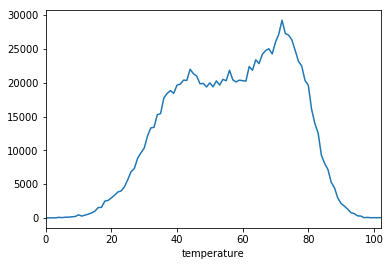

In [26]:
dfSeven.groupby('temperature').size().plot();

In [27]:
dfSeven['temperature'].min()

0.0

In [28]:
# Counting the number of crimes at each temperature

dfCrimesByTemp = dfSeven.groupby('temperature').size()
dfCrimesByTemp = pd.DataFrame(dfCrimesByTemp).reset_index()
dfCrimesByTemp.columns = ['Temperature', 'Count_crime']
dfCrimesByTemp.head()

Temperature  Count_crime
0          0.0            4
1          1.0            3
2          2.0           23
3          3.0           12
4          4.0           86

In [29]:
# Counting the number of hours at each temperature

dfTempNorm = dfSeven.groupby(['temperature','datetime_adj']).size()
dfTempNorm = pd.DataFrame(dfTempNorm).reset_index()
dfTempByHour = dfTempNorm.groupby('temperature').size()
dfTempByHour = pd.DataFrame(dfTempByHour).reset_index()
dfTempByHour.columns = ['Temperature', 'Count_hour']
dfTempByHour.head()

Temperature  Count_hour
0          0.0           1
1          1.0           1
2          2.0           4
3          3.0           3
4          4.0          12

In [30]:
# Merging the new dataframes

dfTempNormalized = pd.merge(dfTempByHour, dfCrimesByTemp, on='Temperature')

In [31]:
# Finding the average count of crime per temperature per hour

dfTempNormalized['avgCrimePerHour'] = dfTempNormalized.Count_crime / dfTempNormalized.Count_hour

In [32]:
dfTempNormalized.head()

Temperature  Count_hour  Count_crime  avgCrimePerHour
0          0.0           1            4         4.000000
1          1.0           1            3         3.000000
2          2.0           4           23         5.750000
3          3.0           3           12         4.000000
4          4.0          12           86         7.166667

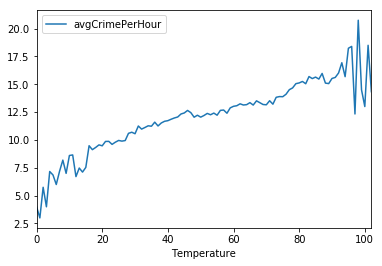

In [33]:
dfTempNormalized.plot('Temperature', 'avgCrimePerHour');

In [34]:
# Fitting an OLS regression

tempMod = smf.ols("avgCrimePerHour ~ Temperature", data=dfTempNormalized)
tempFit = tempMod.fit()
tempFit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        avgCrimePerHour   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     630.0
Date:                Mon, 07 May 2018   Prob (F-statistic):           3.32e-45
Time:                        10:34:58   Log-Likelihood:                -164.10
No. Observations:                 103   AIC:                             332.2
Df Residuals:                     101   BIC:                             337.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       6.9062      0.235     29.367      0.000         6.440     7.373
Temperature     0.1000      0.004     25.099      0.000         0.092     0.108
==============================================================================
Omnibus:                       33.966   Durbin-Watson:                   1.700
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.103
Skew:                          -1.177   Prob(JB):                     7.39e-20
Kurtosis:                       6.872   Cond. No.                         117.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

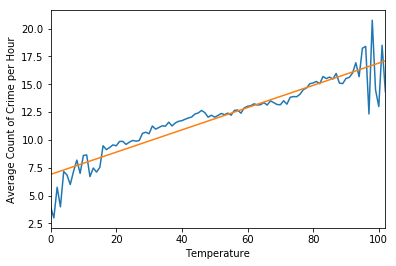

In [35]:
# Plotting the model

dfTempNormalized.plot('Temperature', 'avgCrimePerHour', legend=False).set_ylabel("Average Count of Crime per Hour")
tempFitLine = tempFit.fittedvalues
pl.plot(tempFitLine);

---

# Turning The Method Into A Function

In [36]:
# Defining our function

def weatherCorrelation (dataframe, crime, weatherType, outliers=False, regression=True):
    
    """
    Takes 5 inputs (3 minimum) and generates a normalized plot showing the correlation between 
    weather features and crime types in NYC. Necessary inputs are:
        
        dataframe = the data you are hoping to analyze
        crime = the type of crime you are looking at 
        weatherType = the weather feature you are studying
        
    If "outliers" is True, the function will truncate the data by 20% at both ends, to remove inconsistent
    data at the extremes
    
    If "regression" is True, the function will plot a regression line on the plot that it outputs
    """
      
    
    # Reducing dataframe based on selected crime type
    
    if crime == '7 MAJOR FELONIES':
        dataframe = dataframe
    else:
        dataframe = dataframe.loc[dataframe['OFNS_DESC'] == crime]
    
    # Removing weather outliers - first and last fifth
    
    if outliers == True:
        outCount = ((dataframe[weatherType].max() - dataframe[weatherType].min()) / 5)
        weatherMin = dataframe[weatherType].min() + outCount
        weatherMax = dataframe[weatherType].max() - outCount
        dataframe = dataframe[(dataframe[weatherType] >= weatherMin) & (dataframe[weatherType] <= weatherMax)]
    else:
        dataframe = dataframe
        
    # Reducing crime type by weather event
    
    dfCrimesByWeather = dataframe.groupby(weatherType).size()
    dfCrimesByWeather = pd.DataFrame(dfCrimesByWeather).reset_index()
    dfCrimesByWeather.columns = [weatherType, 'Count_crime']
    
    # Calculating number of hours of each weather pattern
    
    dfWeatherNorm = dataframe.groupby([weatherType,'datetime_adj']).size()
    dfWeatherNorm = pd.DataFrame(dfWeatherNorm).reset_index()
    dfWeatherByHour = dfWeatherNorm.groupby(weatherType).size()
    dfWeatherByHour = pd.DataFrame(dfWeatherByHour).reset_index()
    dfWeatherByHour.columns = [weatherType, 'Count_hour']

    # Getting average Crime per Hour
    
    dfWeatherNormalized = pd.merge(dfCrimesByWeather, dfWeatherByHour, on=weatherType)
    dfWeatherNormalized['CrimePerHour'] = dfWeatherNormalized.Count_crime / dfWeatherNormalized.Count_hour
    
    # Fit a linear/polynomial model 
    
    if weatherType == 'windBearing':
        weatherMod = smf.ols(formula = "CrimePerHour ~ windBearing + I(windBearing**2)", data=dfWeatherNormalized)
    elif weatherType == 'cloudCover':
        weatherMod = smf.ols(formula = "CrimePerHour ~ cloudCover + I(cloudCover**2)", data=dfWeatherNormalized)
    else:
        weatherMod = smf.ols("CrimePerHour ~ " + weatherType, data=dfWeatherNormalized)

    weatherFit = weatherMod.fit()
    weatherFitLine = weatherFit.fittedvalues    
    
        
    if regression==True:

       
        # R-squared, P-Value, and plot

        rSqu = weatherFit.rsquared
        pValue = weatherFit.pvalues[1]
        y = dfWeatherNormalized.plot(weatherType, 'CrimePerHour', title=crime, legend=False)
        y.set_ylabel("Average Count of Crime per Hour")
        z = pl.plot(weatherFitLine);
    
        # Print & Plot    
        
        print("\n" + crime + " Regression Results:\n\nR-Squared Value: ", rSqu, "\nP-Value: ", pValue)
        return y, z
       
    else:
        
        #Print & Plot without Regression
        
        y = dfWeatherNormalized.plot(weatherType, 'CrimePerHour', title=crime, legend=False)
        y.set_ylabel("Average Count of Crime per Hour")
        return y

#### A note on the function: for some reason, there's a bug that causes the regression line to plot incorrectly when outliers are removed. We tested the components of the function piecemeal, and found no issues in the resulting plots. The r-squared and p-values were not impacted by this issue. 


7 MAJOR FELONIES Regression Results:

R-Squared Value:  0.861827522651 
P-Value:  3.32360009378e-45


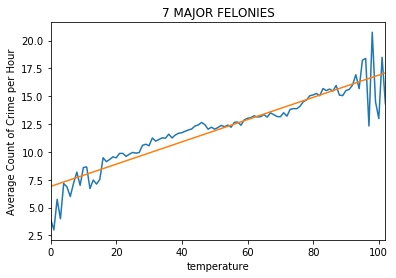

In [37]:
# Testing the function

weatherCorrelation(dfSeven, '7 MAJOR FELONIES', 'temperature', outliers=False, regression=True);

---

# Using the function for exploratory analysis

## Temperature


7 MAJOR FELONIES Regression Results:

R-Squared Value:  0.861827522651 
P-Value:  3.32360009378e-45

ROBBERY Regression Results:

R-Squared Value:  0.241843596689 
P-Value:  1.7649656052e-07

FELONY ASSAULT Regression Results:

R-Squared Value:  0.51867654233 
P-Value:  1.45007513761e-17

MURDER & NON-NEGL. MANSLAUGHTER Regression Results:

R-Squared Value:  0.00788614508176 
P-Value:  0.413388231183

GRAND LARCENY Regression Results:

R-Squared Value:  0.790389703492 
P-Value:  1.0506117305e-35

BURGLARY Regression Results:

R-Squared Value:  0.47493327881 
P-Value:  1.62440378978e-15

GRAND LARCENY OF MOTOR VEHICLE Regression Results:

R-Squared Value:  0.335479871017 
P-Value:  2.73567050373e-10

RAPE Regression Results:

R-Squared Value:  0.00118942002961 
P-Value:  0.738693122041


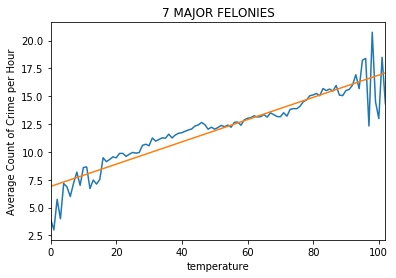

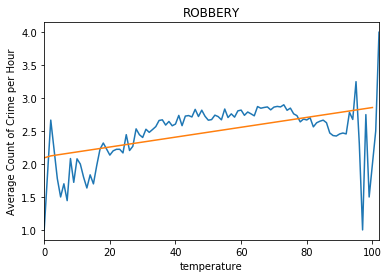

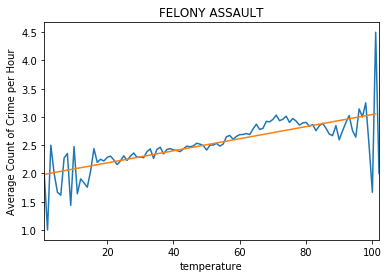

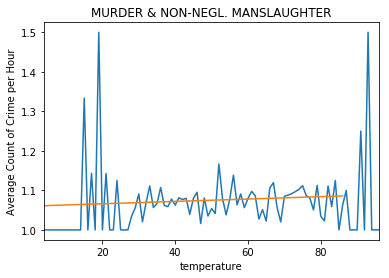

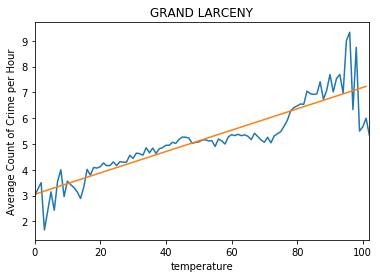

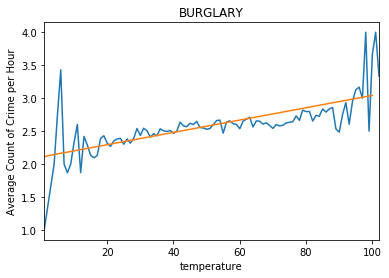

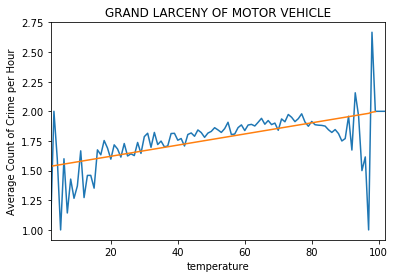

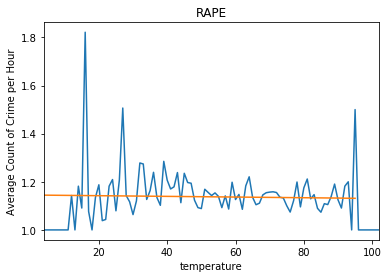

In [38]:
felonyTypes = ['7 MAJOR FELONIES', 'ROBBERY', 'FELONY ASSAULT', 'MURDER & NON-NEGL. MANSLAUGHTER', 'GRAND LARCENY', 'BURGLARY',
                 'GRAND LARCENY OF MOTOR VEHICLE', 'RAPE']

weatherTypes = ['dewPoint', 'apparentTemperature', 'temperature', 'visibility', 'precipIntensity',
                'windBearing', 'windSpeed', 'pressure', 'precipAccumulation', 'cloudCover']

for i in felonyTypes:
    weatherCorrelation(dfSeven, i, 'temperature', outliers=False, regression=True)

## Apparent Temperature


7 MAJOR FELONIES Regression Results:

R-Squared Value:  0.892348540745 
P-Value:  1.58827337393e-38

ROBBERY Regression Results:

R-Squared Value:  0.593709446407 
P-Value:  1.0163086917e-16

FELONY ASSAULT Regression Results:

R-Squared Value:  0.883607729659 
P-Value:  3.10000086584e-37

MURDER & NON-NEGL. MANSLAUGHTER Regression Results:

R-Squared Value:  0.0297423966375 
P-Value:  0.14455903299

GRAND LARCENY Regression Results:

R-Squared Value:  0.726452035092 
P-Value:  2.24090718122e-23

BURGLARY Regression Results:

R-Squared Value:  0.537084069946 
P-Value:  2.39600535857e-14

GRAND LARCENY OF MOTOR VEHICLE Regression Results:

R-Squared Value:  0.688223679585 
P-Value:  6.37956392732e-21

RAPE Regression Results:

R-Squared Value:  0.0167882554235 
P-Value:  0.264614625497


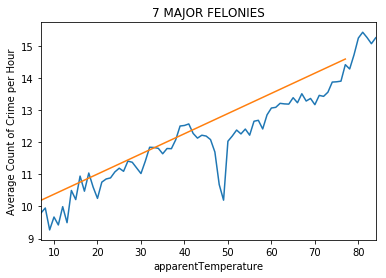

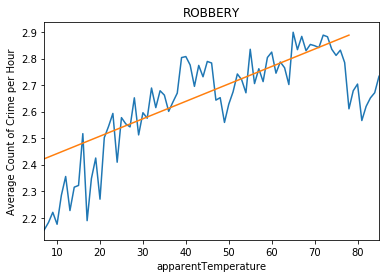

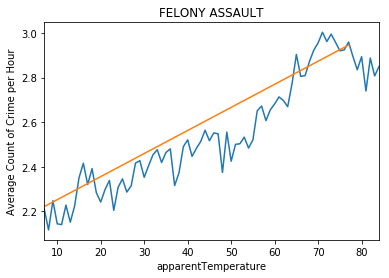

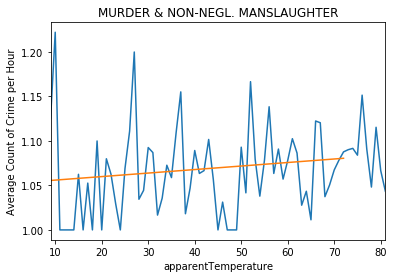

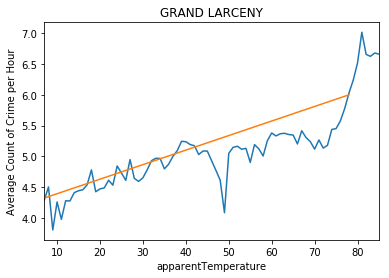

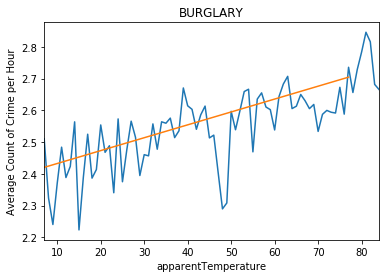

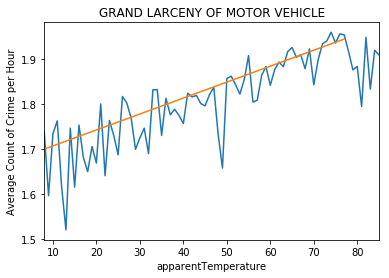

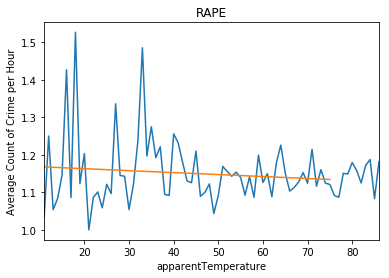

In [39]:
weatherTypes = ['dewPoint', 'apparentTemperature', 'temperature', 'visibility', 'precipIntensity',
                'windBearing', 'windSpeed', 'pressure', 'precipAccumulation', 'cloudCover']

for i in felonyTypes:
    weatherCorrelation(dfSeven, i, 'apparentTemperature', outliers=True)

## Dew Point


7 MAJOR FELONIES Regression Results:

R-Squared Value:  0.915701107545 
P-Value:  9.27590032775e-32

ROBBERY Regression Results:

R-Squared Value:  0.623186102548 
P-Value:  1.80190802807e-13

FELONY ASSAULT Regression Results:

R-Squared Value:  0.880270853025 
P-Value:  1.74655903414e-27

MURDER & NON-NEGL. MANSLAUGHTER Regression Results:

R-Squared Value:  0.0138784521666 
P-Value:  0.391666015783

GRAND LARCENY Regression Results:

R-Squared Value:  0.755276313627 
P-Value:  9.2765843476e-19

BURGLARY Regression Results:

R-Squared Value:  0.648520052204 
P-Value:  4.28597045986e-14

GRAND LARCENY OF MOTOR VEHICLE Regression Results:

R-Squared Value:  0.671803235077 
P-Value:  3.63462636453e-15

RAPE Regression Results:

R-Squared Value:  0.00303223265968 
P-Value:  0.686884912304


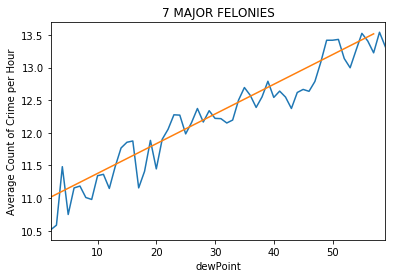

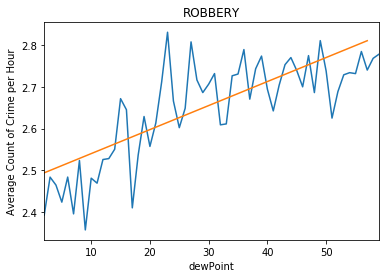

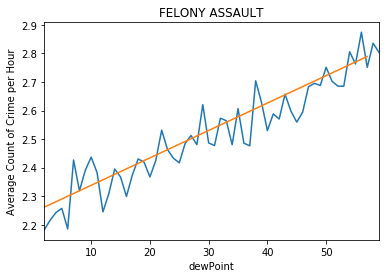

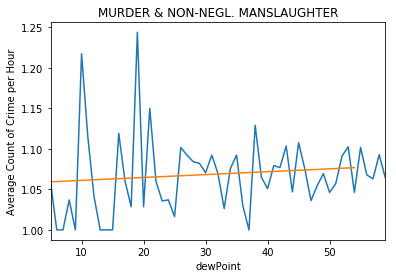

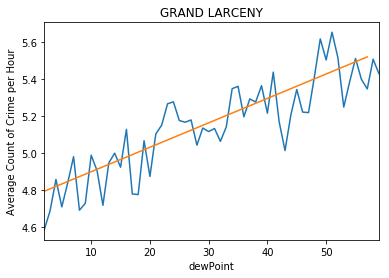

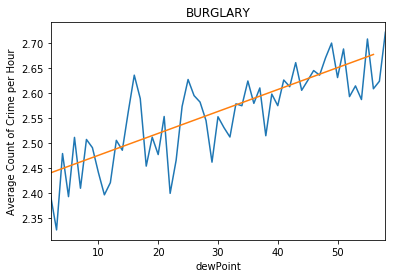

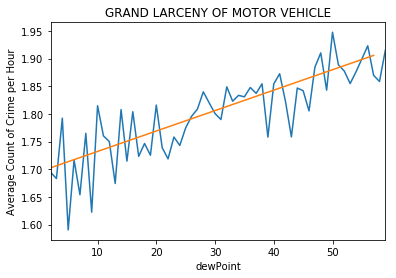

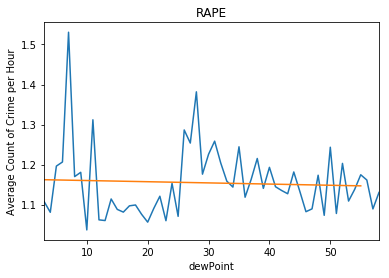

In [40]:
weatherTypes = ['dewPoint', 'apparentTemperature', 'temperature', 'visibility', 'precipIntensity',
                'windBearing', 'windSpeed', 'pressure', 'precipAccumulation', 'cloudCover']

for i in felonyTypes:
    weatherCorrelation(dfSeven, i, 'dewPoint', outliers=True)

## Visibility


7 MAJOR FELONIES Regression Results:

R-Squared Value:  0.355562743005 
P-Value:  5.91647008774e-11

ROBBERY Regression Results:

R-Squared Value:  0.110273452082 
P-Value:  0.000737322116754

FELONY ASSAULT Regression Results:

R-Squared Value:  0.478240632833 
P-Value:  1.64748085537e-15

MURDER & NON-NEGL. MANSLAUGHTER Regression Results:

R-Squared Value:  0.00772461046057 
P-Value:  0.389476127669

GRAND LARCENY Regression Results:

R-Squared Value:  0.251222864974 
P-Value:  1.08730654127e-07

BURGLARY Regression Results:

R-Squared Value:  5.55103397715e-06 
P-Value:  0.981439332275

GRAND LARCENY OF MOTOR VEHICLE Regression Results:

R-Squared Value:  0.0619565051402 
P-Value:  0.0125161136942

RAPE Regression Results:

R-Squared Value:  0.03306638487 
P-Value:  0.0716440838703


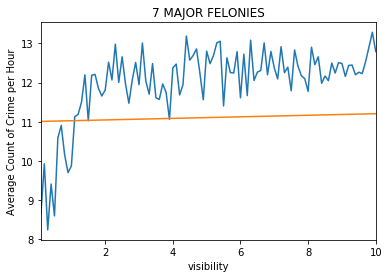

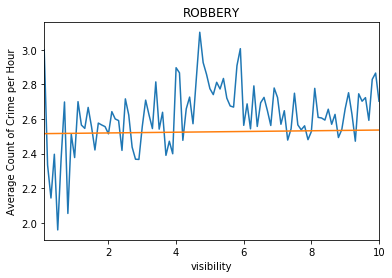

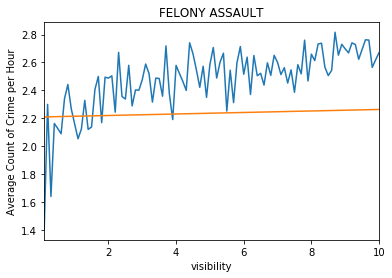

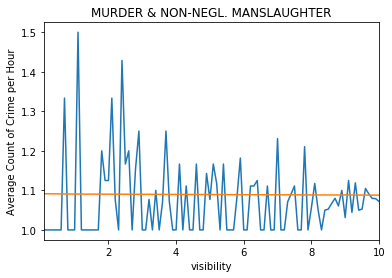

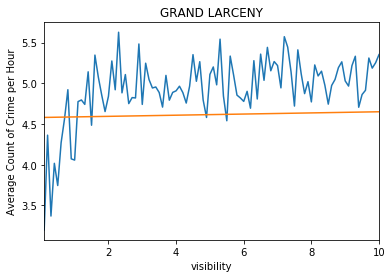

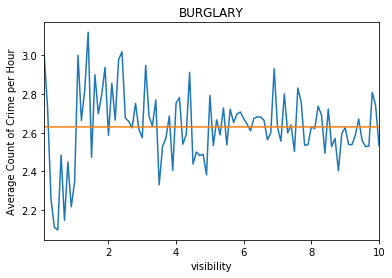

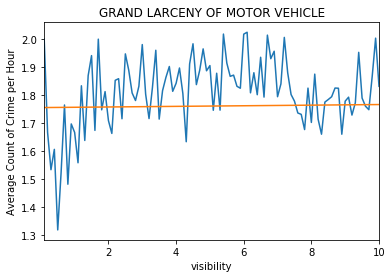

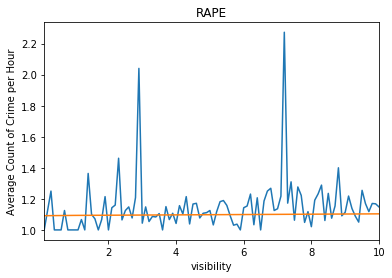

In [41]:
weatherTypes = ['dewPoint', 'apparentTemperature', 'temperature', 'visibility', 'precipIntensity',
                'windBearing', 'windSpeed', 'pressure', 'precipAccumulation', 'cloudCover']

for i in felonyTypes:
    weatherCorrelation(dfSeven, i, 'visibility')

## Wind Speed


7 MAJOR FELONIES Regression Results:

R-Squared Value:  7.73215643091e-05 
P-Value:  0.95821351682

ROBBERY Regression Results:

R-Squared Value:  0.378107847523 
P-Value:  3.99631357262e-05

FELONY ASSAULT Regression Results:

R-Squared Value:  0.614983405167 
P-Value:  9.35807445978e-09

MURDER & NON-NEGL. MANSLAUGHTER Regression Results:

R-Squared Value:  0.00996028028249 
P-Value:  0.586813659939

GRAND LARCENY Regression Results:

R-Squared Value:  0.151622843357 
P-Value:  0.0156750118382

BURGLARY Regression Results:

R-Squared Value:  0.504684135253 
P-Value:  5.84171742496e-07

GRAND LARCENY OF MOTOR VEHICLE Regression Results:

R-Squared Value:  0.0187615641122 
P-Value:  0.412200700221

RAPE Regression Results:

R-Squared Value:  0.388631057556 
P-Value:  0.000138110122768


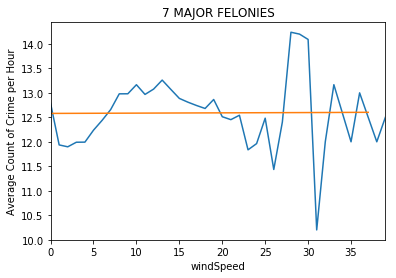

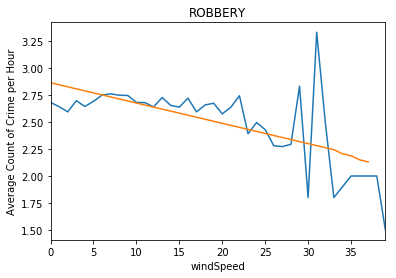

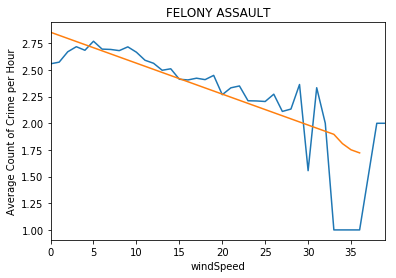

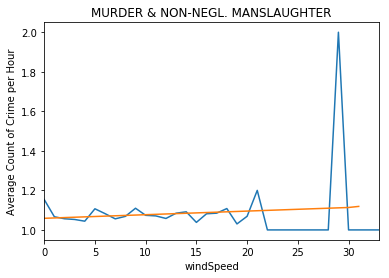

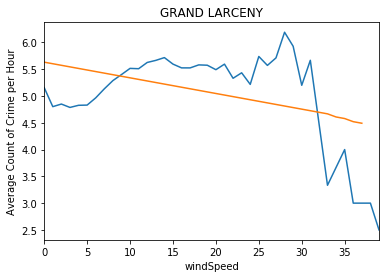

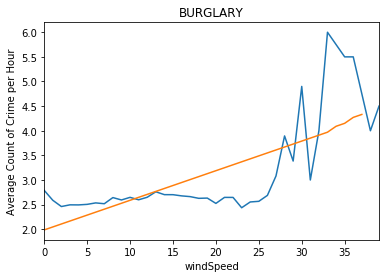

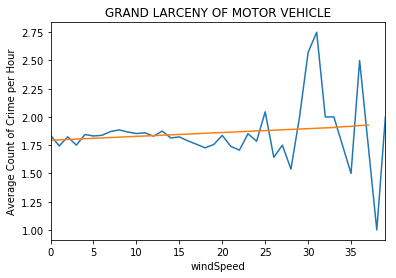

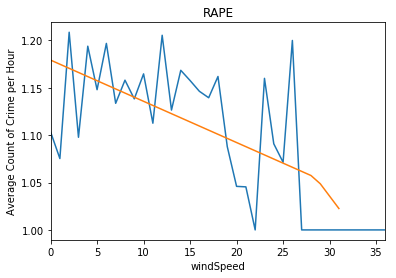

In [42]:
weatherTypes = ['dewPoint', 'apparentTemperature', 'temperature', 'visibility', 'precipIntensity',
                'windBearing', 'windSpeed', 'pressure', 'precipAccumulation', 'cloudCover']

for i in felonyTypes:
    weatherCorrelation(dfSeven, i, 'windSpeed')

## Pressure


7 MAJOR FELONIES Regression Results:

R-Squared Value:  0.0503456958561 
P-Value:  0.0468163836125

ROBBERY Regression Results:

R-Squared Value:  0.15619689463 
P-Value:  0.000410354963644

FELONY ASSAULT Regression Results:

R-Squared Value:  0.190497969704 
P-Value:  8.09739449595e-05

MURDER & NON-NEGL. MANSLAUGHTER Regression Results:

R-Squared Value:  0.0401648508072 
P-Value:  0.142352938068

GRAND LARCENY Regression Results:

R-Squared Value:  0.0746752466309 
P-Value:  0.0154890268065

BURGLARY Regression Results:

R-Squared Value:  0.131666790098 
P-Value:  0.0010946937562

GRAND LARCENY OF MOTOR VEHICLE Regression Results:

R-Squared Value:  0.0165272189892 
P-Value:  0.265161828319

RAPE Regression Results:

R-Squared Value:  0.00347822688162 
P-Value:  0.648873687662


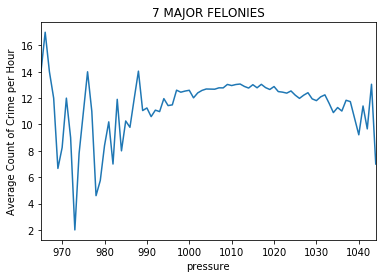

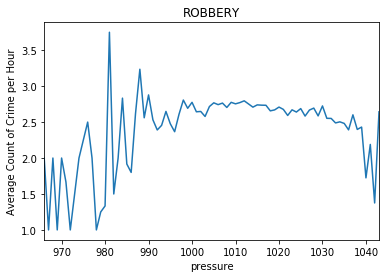

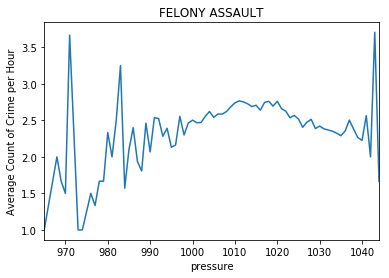

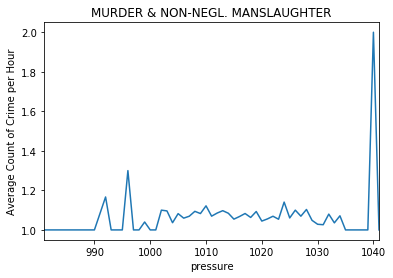

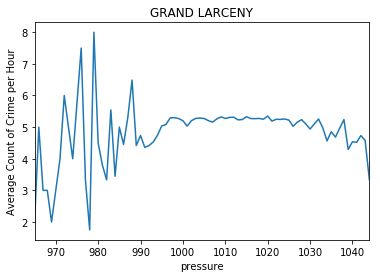

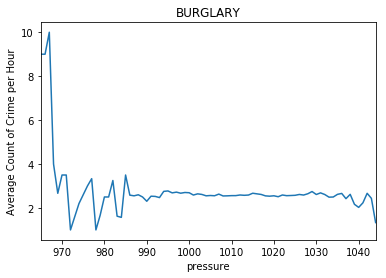

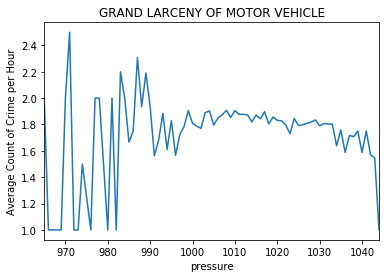

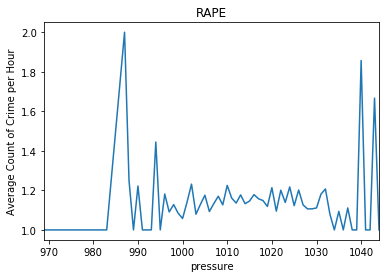

In [43]:
weatherTypes = ['dewPoint', 'apparentTemperature', 'temperature', 'visibility', 'precipIntensity',
                'windBearing', 'windSpeed', 'pressure', 'precipAccumulation', 'cloudCover']

for i in felonyTypes:
    weatherCorrelation(dfSeven, i, 'pressure')

## Precipitation - Intensity


7 MAJOR FELONIES Regression Results:

R-Squared Value:  0.0153628980677 
P-Value:  0.349634129947

ROBBERY Regression Results:

R-Squared Value:  0.112125369654 
P-Value:  0.0116502046953

FELONY ASSAULT Regression Results:

R-Squared Value:  0.000208152254576 
P-Value:  0.915171845586

MURDER & NON-NEGL. MANSLAUGHTER Regression Results:

R-Squared Value:  0.00041144266995 
P-Value:  0.920009516594

GRAND LARCENY Regression Results:

R-Squared Value:  0.000759897890699 
P-Value:  0.838706430135

BURGLARY Regression Results:

R-Squared Value:  0.00872271006061 
P-Value:  0.485601707349

GRAND LARCENY OF MOTOR VEHICLE Regression Results:

R-Squared Value:  0.0319670666414 
P-Value:  0.200211973949

RAPE Regression Results:

R-Squared Value:  0.00812785107174 
P-Value:  0.590381291616


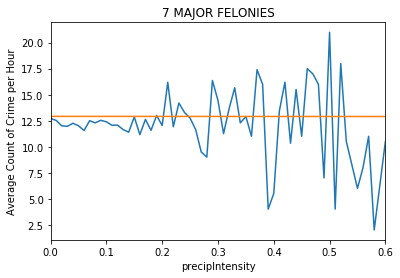

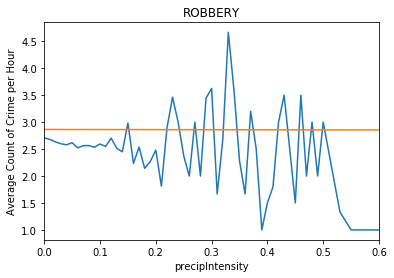

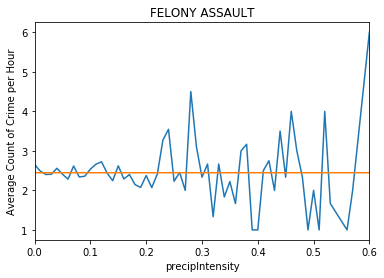

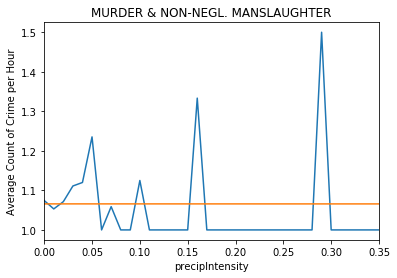

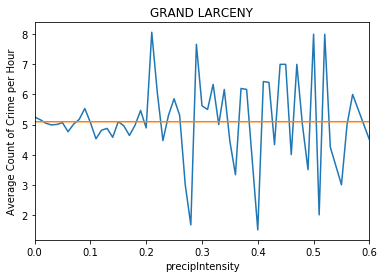

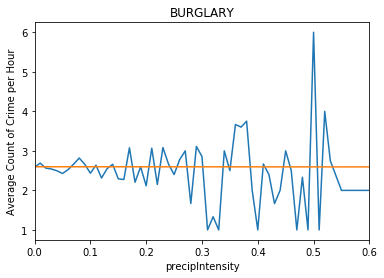

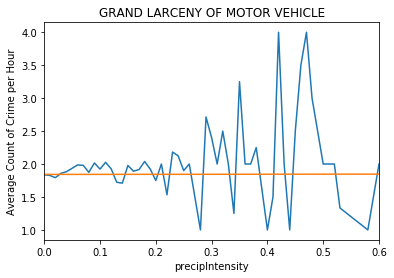

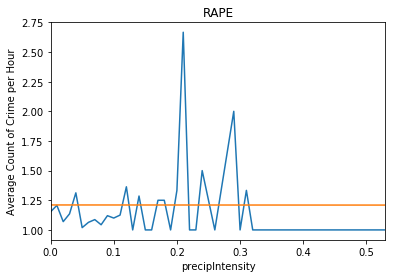

In [44]:
# Truncating the data for plot visibility

dfPrecipIntens = dfSeven.loc[dfSeven['precipIntensity'] <= 0.6]

weatherTypes = ['dewPoint', 'apparentTemperature', 'temperature', 'visibility', 'precipIntensity',
                'windBearing', 'windSpeed', 'pressure', 'precipAccumulation', 'cloudCover']

for i in felonyTypes:
    weatherCorrelation(dfPrecipIntens, i, 'precipIntensity')

## Precipitation - Accumulation
#### For precipitation accumulation, we rarely see amounts higher than ~3 inches. Because of this, we chose to run the function on a dataframe that cuts off precipitation amounts higher than 3

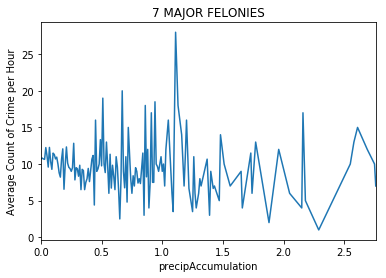

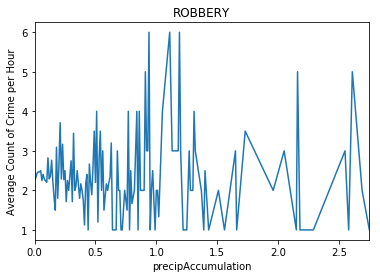

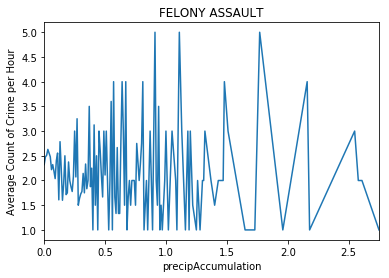

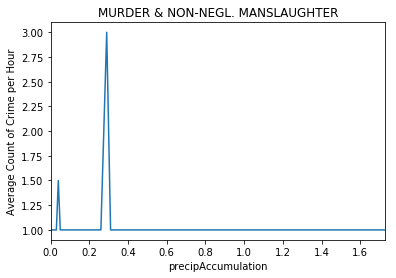

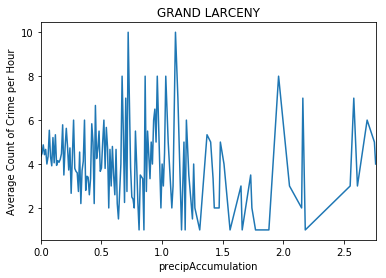

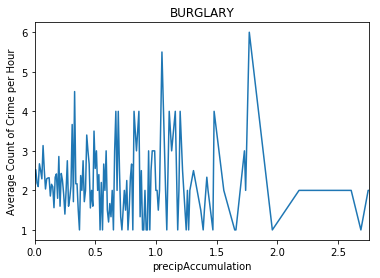

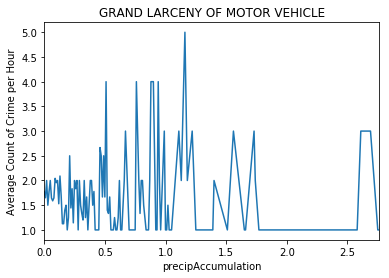

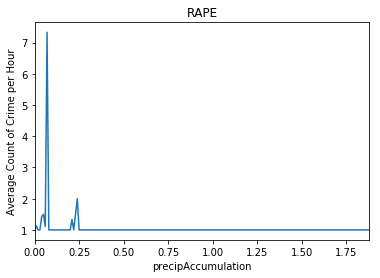

In [45]:
dfPrecipAccum = dfSeven.loc[dfSeven['precipAccumulation'] <= 3]

weatherTypes = ['dewPoint', 'apparentTemperature', 'temperature', 'visibility', 'precipIntensity',
                'windBearing', 'windSpeed', 'pressure', 'precipAccumulation', 'cloudCover']

for i in felonyTypes:
    weatherCorrelation(dfPrecipAccum, i, 'precipAccumulation', regression=False)

## Cloud Cover


7 MAJOR FELONIES Regression Results:

R-Squared Value:  0.25237412209 
P-Value:  8.82934207572e-06

ROBBERY Regression Results:

R-Squared Value:  0.174841958532 
P-Value:  0.0979647202503

FELONY ASSAULT Regression Results:

R-Squared Value:  0.298321643121 
P-Value:  0.76294747303

MURDER & NON-NEGL. MANSLAUGHTER Regression Results:

R-Squared Value:  0.0259446317789 
P-Value:  0.959833528623

GRAND LARCENY Regression Results:

R-Squared Value:  0.367473369361 
P-Value:  1.15094991875e-05

BURGLARY Regression Results:

R-Squared Value:  0.192921045439 
P-Value:  0.00425402857331

GRAND LARCENY OF MOTOR VEHICLE Regression Results:

R-Squared Value:  0.0592257143604 
P-Value:  0.544348452856

RAPE Regression Results:

R-Squared Value:  0.0147731883929 
P-Value:  0.822664908183


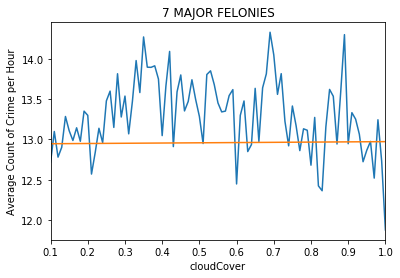

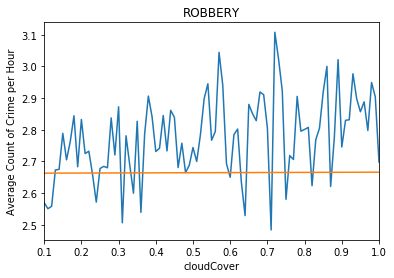

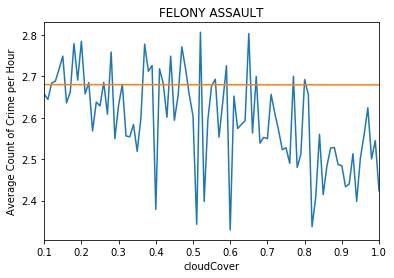

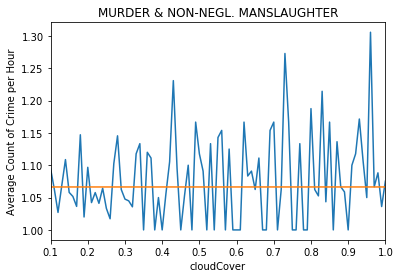

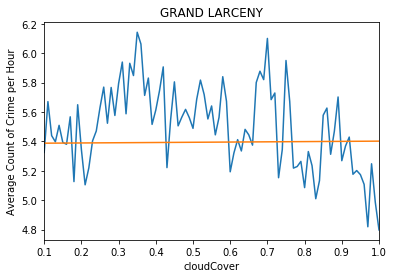

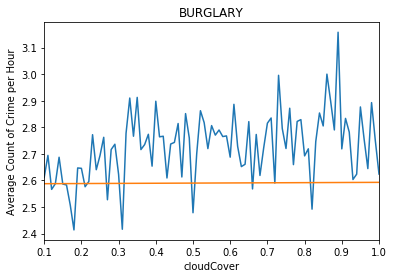

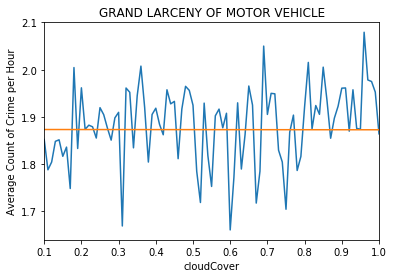

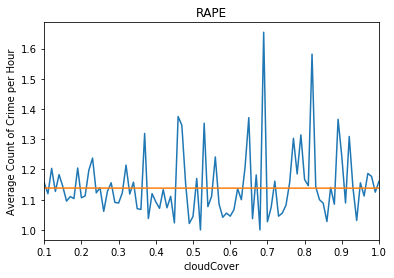

In [46]:
dfCloud = dfSeven.loc[dfSeven['cloudCover'] >= 0.1]

weatherTypes = ['dewPoint', 'apparentTemperature', 'temperature', 'visibility', 'precipIntensity',
                'windBearing', 'windSpeed', 'pressure', 'precipAccumulation', 'cloudCover']

for i in felonyTypes:
    weatherCorrelation(dfCloud, i, 'cloudCover')

## Wind Bearing


7 MAJOR FELONIES Regression Results:

R-Squared Value:  0.617267270491 
P-Value:  5.43136526658e-74

ROBBERY Regression Results:

R-Squared Value:  0.296272083089 
P-Value:  6.65790492674e-29

FELONY ASSAULT Regression Results:

R-Squared Value:  0.336181064325 
P-Value:  1.42162431295e-33

MURDER & NON-NEGL. MANSLAUGHTER Regression Results:

R-Squared Value:  0.00435895665365 
P-Value:  0.601951754863

GRAND LARCENY Regression Results:

R-Squared Value:  0.425955706184 
P-Value:  2.36943190571e-41

BURGLARY Regression Results:

R-Squared Value:  0.0728859838451 
P-Value:  0.470663226717

GRAND LARCENY OF MOTOR VEHICLE Regression Results:

R-Squared Value:  0.186587536065 
P-Value:  1.46128226615e-17

RAPE Regression Results:

R-Squared Value:  0.0158158072828 
P-Value:  0.236252944798


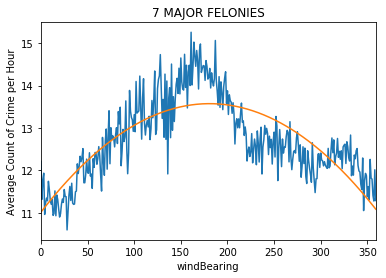

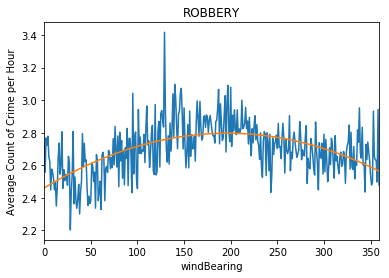

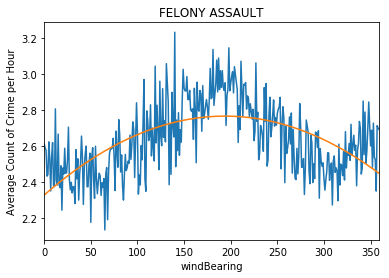

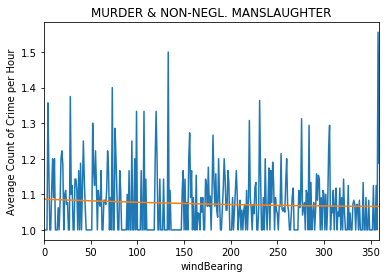

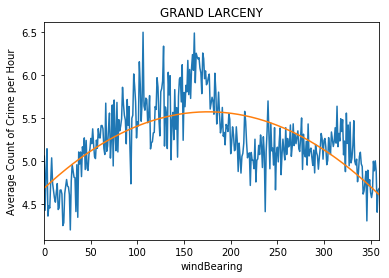

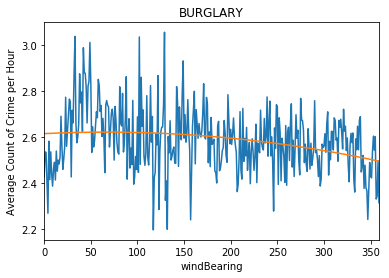

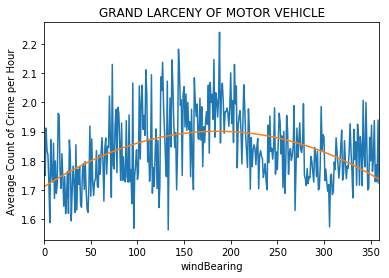

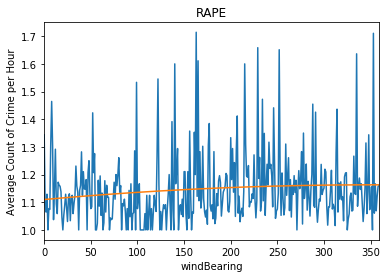

In [47]:
weatherTypes = ['dewPoint', 'apparentTemperature', 'temperature', 'visibility', 'precipIntensity',
                'windBearing', 'windSpeed', 'pressure', 'precipAccumulation', 'cloudCover']

for i in felonyTypes:
    weatherCorrelation(dfSeven, i, 'windBearing', regression=True)

---

# Examining Wind Bearing Further

## Reducing to outdoor crimes only

In [48]:
# Creating dataframes for what we consider indoor and outdoor crimes

maybeOutdoor = ['STREET', 'PARK/PLAYGROUND', 'PARKING LOT/GARAGE (PUBLIC)', 'GAS STATION', 'TUNNEL',
       'TRANSIT - NYC SUBWAY', 'BUS (NYC TRANSIT)', 'PARKING LOT/GARAGE (PRIVATE)',
       'FERRY/FERRY TERMINAL', 'CONSTRUCTION SITE', 'BUS STOP', 'BRIDGE', 'OPEN AREAS (OPEN LOTS)', 'MARINA/PIER',
       'HIGHWAY/PARKWAY', 'BUS TERMINAL', 'CEMETERY', 'TRAMWAY']

outdoor = ['STREET', 'PARK/PLAYGROUND', 'TUNNEL', 'CONSTRUCTION SITE', 'BUS STOP', 'BRIDGE', 'OPEN AREAS (OPEN LOTS)',
           'MARINA/PIER', 'HIGHWAY/PARKWAY', 'BUS TERMINAL', 'CEMETERY']

dfSevenMaybeOutdoor = dfSeven.loc[dfSeven['PREM_TYP_DESC'].isin(maybeOutdoor)]
dfSevenOutdoor = dfSeven.loc[dfSeven['PREM_TYP_DESC'].isin(outdoor)]
dfSevenIndoor = dfSeven.loc[~dfSeven['PREM_TYP_DESC'].isin(maybeOutdoor)]

In [49]:
# Cleaning the dataframe in preparation for the function

dfSevenMaybeOutdoor = dfSevenMaybeOutdoor.drop(['level_0', 'index'], axis=1)
dfSevenMaybeOutdoor  = pd.DataFrame(dfSevenMaybeOutdoor).reset_index()

dfSevenOutdoor = dfSevenOutdoor.drop(['level_0', 'index'], axis=1)
dfSevenOutdoor  = pd.DataFrame(dfSevenOutdoor).reset_index()

dfSevenIndoor = dfSevenIndoor.drop(['level_0', 'index'], axis=1)
dfSevenIndoor  = pd.DataFrame(dfSevenIndoor).reset_index()

### There's an issue here where we cannot reset the index of the new dataframe... this is impacting the ability to run through the function we created, which requires the index to reset... for some reason, it DOES still work for certain types of crime (all, robbery, and felony assault)

In [50]:
# for i in felonyTypes:
#     weatherCorrelation(dfSevenOutdoor, i, 'windBearing')


7 MAJOR FELONIES Regression Results:

R-Squared Value:  0.570100597922 
P-Value:  2.09127702223e-66


(<matplotlib.axes._subplots.AxesSubplot at 0x7f55b40e5be0>,
 [<matplotlib.lines.Line2D at 0x7f55b4db2550>])

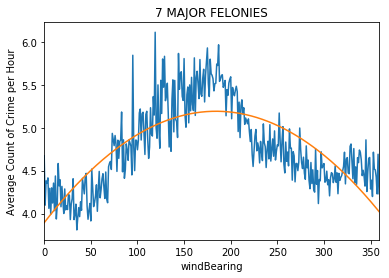

In [51]:
weatherCorrelation(dfSevenOutdoor, '7 MAJOR FELONIES', 'windBearing');

#### The above plot shows that, when we filter for crimes that we believe to have taken place outdoors, we still see the same distribution. 


7 MAJOR FELONIES Regression Results:

R-Squared Value:  0.414919767943 
P-Value:  1.50280323581e-40


(<matplotlib.axes._subplots.AxesSubplot at 0x7f55b4db2b00>,
 [<matplotlib.lines.Line2D at 0x7f55b4da7588>])

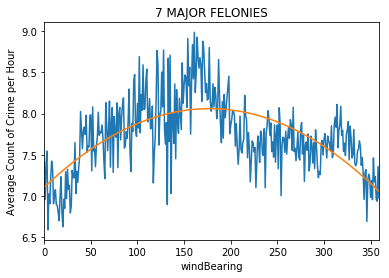

In [52]:
weatherCorrelation(dfSevenIndoor, '7 MAJOR FELONIES', 'windBearing');

#### The above figure shows the distribution if we exclude outdoor crimes and only look at those taking place indoors. We see that the distribution holds

### Examining temperature and wind bearing for correlation

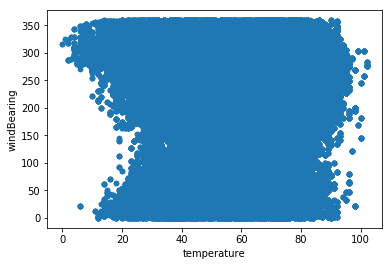

In [53]:
dfSeven.plot.scatter(x='temperature', y='windBearing');

#### This is kind of messy...let's take a random sampling of every 3000th row

In [54]:
dfSample = dfSeven.iloc[::3000, :]

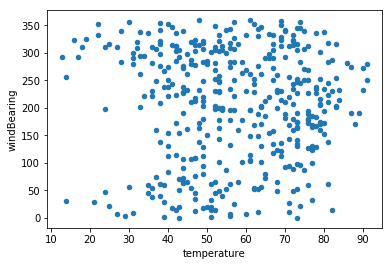

In [55]:
dfSample.plot.scatter(x='temperature', y='windBearing');

#### This shows us with a little more definition that southern winds are less likely to occur at lower temperatures. What would happen if we plot crimes that happen at 40 degrees (or higher), eliminating this hole?

In [56]:
dvSevenHigherTemps = dfSeven[(dfSeven['temperature'] >= 40)]

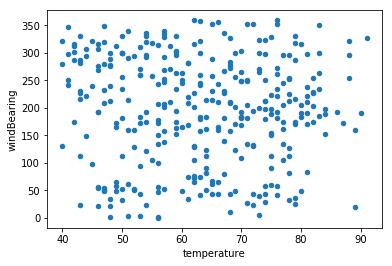

In [57]:
dfSevenHigherTempsSample = dvSevenHigherTemps.iloc[::3000, :]
dfSevenHigherTempsSample.plot.scatter(x='temperature', y='windBearing');

#### The above plot reveals the general randomness of wind bearing against temperature, once we set the lower limit to 40 degrees. Let's take a look at the correlation again using the new dataframe, so as to remove any low-temperature extremes.


7 MAJOR FELONIES Regression Results:

R-Squared Value:  0.487708432664 
P-Value:  1.20896095652e-53


(<matplotlib.axes._subplots.AxesSubplot at 0x7f55a4f1c550>,
 [<matplotlib.lines.Line2D at 0x7f55a4f17128>])

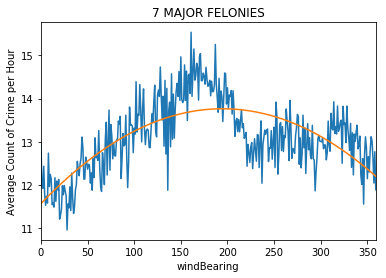

In [58]:
weatherCorrelation(dvSevenHigherTemps, '7 MAJOR FELONIES', 'windBearing')

#### Limiting our data to higher temperatures (greater than 40 degrees) still leaves us with a visible correlation... what else could account for this? Maybe it's a temporal correlation, with southern winds occuring more frequently in the summer.

#### Before we get into that though, let's look at 10 degree increments to see if the pattern will exist on a smaller scale..

In [59]:
dfSevenTenTemps = dfSeven[(dfSeven['temperature'] >= 60) & (dfSeven['temperature'] <= 70)]


7 MAJOR FELONIES Regression Results:

R-Squared Value:  0.226824471771 
P-Value:  3.37670393259e-19


(<matplotlib.axes._subplots.AxesSubplot at 0x7f55a4f32160>,
 [<matplotlib.lines.Line2D at 0x7f55a4f2d550>])

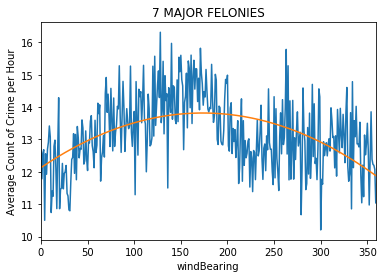

In [60]:
weatherCorrelation(dfSevenTenTemps, '7 MAJOR FELONIES', 'windBearing')

#### You don't get much from this... I tested this method for all intervals of 10 between 20 and 100 degrees, and at no point do you see a clear pattern. It's only when you expand the spread that the pattern reveals itself

## Temporal Analysis of Wind Bearing

In [61]:
weather['month'] = weather['datetime_adj'].dt.month

In [62]:
# 4 continuous days
n = 8
windDays = weather.iloc[0:(24*n)]

# midnight
dailyWeatherMidnight = weather.iloc[::24, :]
dailyWeatherOneYear = dailyWeatherMidnight.iloc[0:365]
dailyWeatherTwoYears = dailyWeatherMidnight.iloc[0:730]
weeklyWeatherMidnight = dailyWeatherMidnight.iloc[::7, :]
weeklyWeatherOneYear = weeklyWeatherMidnight.iloc[0:52]

# noon
dailyWeatherNoon = weather.iloc[12::24, :] 
dailyWeatherNoonOneYear = dailyWeatherNoon.iloc[0:365]
dailyWeatherNoonTwoYears = dailyWeatherNoon.iloc[0:730]
weeklyWeatherNoon = dailyWeatherNoon.iloc[::7, :]
weeklyWeatherNoonOneYear = weeklyWeatherNoon.iloc[0:52]

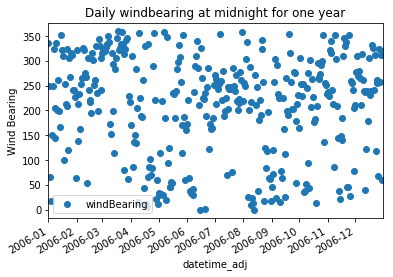

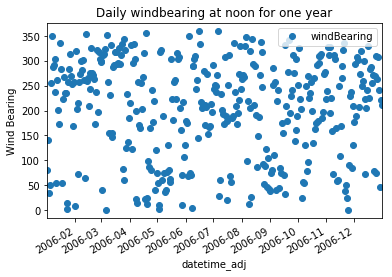

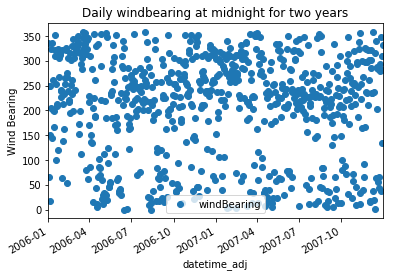

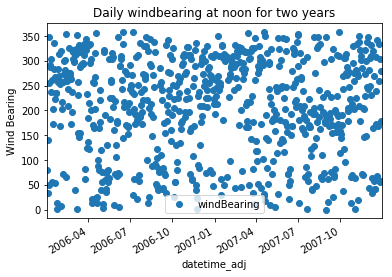

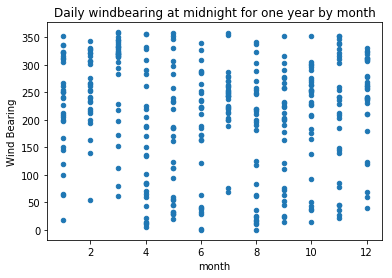

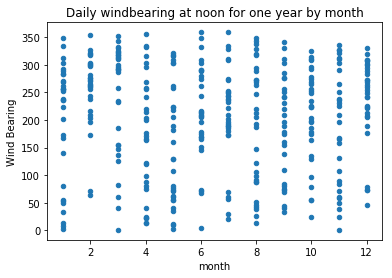

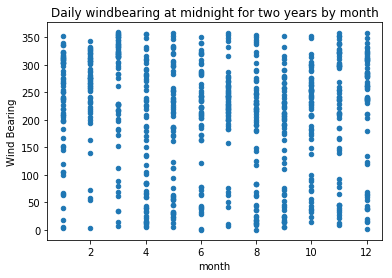

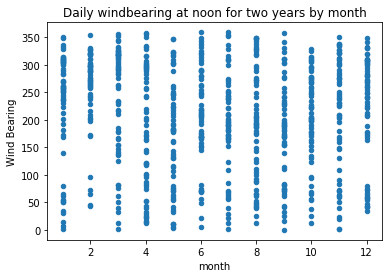

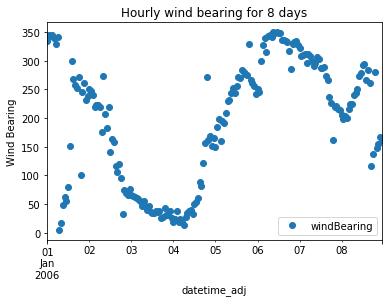

In [92]:
# Looking at the relationship of wind bearing and time of year at various scales

dailyWeatherOneYear.plot(x='datetime_adj', y='windBearing', style='o', title="Daily windbearing at midnight for one year")\
.set_ylabel("Wind Bearing")

dailyWeatherNoonOneYear.plot(x='datetime_adj', y='windBearing', style='o', title="Daily windbearing at noon for one year")\
.set_ylabel("Wind Bearing")

dailyWeatherTwoYears.plot(x='datetime_adj', y='windBearing', style='o', title="Daily windbearing at midnight for two years")\
.set_ylabel("Wind Bearing")

dailyWeatherNoonTwoYears.plot(x='datetime_adj', y='windBearing', style='o', title="Daily windbearing at noon for two years")\
.set_ylabel("Wind Bearing")

dailyWeatherOneYear.plot.scatter(x='month', y='windBearing', style='o', \
                                 title="Daily windbearing at midnight for one year by month").set_ylabel("Wind Bearing")

dailyWeatherNoonOneYear.plot.scatter(x='month', y='windBearing', style='o', \
                                     title="Daily windbearing at noon for one year by month").set_ylabel("Wind Bearing")

dailyWeatherTwoYears.plot.scatter(x='month', y='windBearing', style='o', \
                                  title="Daily windbearing at midnight for two years by month").set_ylabel("Wind Bearing")

dailyWeatherNoonTwoYears.plot.scatter(x='month', y='windBearing', style='o', \
                                      title="Daily windbearing at noon for two years by month").set_ylabel("Wind Bearing")

windDays.plot(x='datetime_adj', y='windBearing', style='o', title="Hourly wind bearing for 8 days")\
.set_ylabel("Wind Bearing");

#### Looking at data for 365 continuous days, 730 continuous days, and 52 continuous weeks, there isn't a discernable temporal distribution of wind bearing. There are small holes here and there, but those do not appear to be based on any discernable pattern. 

# Mapping Weather & Crime

In [64]:
import choroplethNYC as cp # authored by Dr. Federica Bianco
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame

## Southerly Winds

In [84]:
# Filter out crimes that occur when wind is not coming from the south

dfSouth = dfSeven.loc[(dfSeven['windBearing'] >= 157.5) & (dfSeven['windBearing'] <= 202.5)]

In [85]:
geometry = [Point(xy) for xy in zip(dfSouth.Longitude, dfSouth.Latitude)]
crs = {'init': 'epsg:4326'}
gdfSouth = GeoDataFrame(dfSouth, crs=crs, geometry=geometry)

In [86]:
gdfSouth.head()

level_0  index  CMPLNT_NUM CMPLNT_FR_DT CMPLNT_FR_TM CMPLNT_TO_DT  \
248      986    986   315719041   12/22/2015     08:00:00   12/28/2015   
269     1080   1080   784751273   07/17/2015     00:01:00   07/24/2015   
273     1089   1089   304095347   09/27/2014     20:51:00          NaN   
274     1092   1092   840272043   08/19/2011     12:00:00   12/31/2015   
522     2173   2174   582920285   12/24/2015     00:01:00          NaN   

    CMPLNT_TO_TM      RPT_DT  KY_CD      OFNS_DESC  \
248     13:00:00  12/31/2015    109  GRAND LARCENY   
269     23:59:00  12/31/2015    109  GRAND LARCENY   
273          NaN  12/31/2015    109  GRAND LARCENY   
274     11:00:00  12/31/2015    107       BURGLARY   
522          NaN  12/30/2015    109  GRAND LARCENY   

                         ...                       pressure        summary  \
248                      ...                         1017.0          Clear   
269                      ...                         1018.0          Clear   
273                      ...                         1021.0          Clear   
274                      ...                         1014.0  Partly Cloudy   
522                      ...                         1010.0          Clear   

    temperature          time visibility windBearing  windSpeed  \
248        54.0  1.450789e+09        9.8       176.0        6.0   
269        69.0  1.437106e+09       10.0       199.0        6.0   
273        73.0  1.411866e+09       10.0       187.0        4.0   
274        78.0  1.313770e+09        9.4       195.0        5.0   
522        62.0  1.450933e+09        4.2       187.0       10.0   

             datetime_y        datetime_adj  \
248 2015-12-22 13:00:00 2015-12-22 08:00:00   
269 2015-07-17 04:00:00 2015-07-17 00:00:00   
273 2014-09-28 01:00:00 2014-09-27 21:00:00   
274 2011-08-19 16:00:00 2011-08-19 12:00:00   
522 2015-12-24 05:00:00 2015-12-24 00:00:00   

                                         geometry  
248       POINT (-73.98847201699999 40.739402283)  
269        POINT (-73.98356551100001 40.77855547)  
273  POINT (-73.99045573399999 40.77162029300001)  
274            POINT (-73.785240235 40.701226017)  
522             POINT (-73.97490979 40.732908785)  

[5 rows x 49 columns]

#### Importing Precincts Shapefile

In [69]:
!wget "https://data.cityofnewyork.us/api/geospatial/78dh-3ptz?method=export&format=Shapefile"

In [70]:
!unzip "78dh-3ptz?method=export&format=Shapefile"

In [71]:
filename = "geo_export_4c46ef28-7ec4-4d8d-b918-d3ce68c2fa56.shp"
precincts = gpd.GeoDataFrame.from_file(filename)

In [72]:
precincts.head()

shape_area    shape_leng  precinct  \
0  4.730176e+07  80586.154615       1.0   
1  1.808880e+07  18676.124259       5.0   
2  2.213193e+07  27182.610113       6.0   
3  1.836402e+07  17301.308682       7.0   
4  2.139423e+07  19773.233410       9.0   

                                            geometry  
0  (POLYGON ((-74.0438776157395 40.69018767637665...  
1  POLYGON ((-73.98863862848766 40.72293372026369...  
2  POLYGON ((-73.99968392160721 40.73855224865976...  
3  POLYGON ((-73.97345389423181 40.718962954076, ...  
4  POLYGON ((-73.97160900246391 40.72672340116989...

### Plotting Southerly Crimes

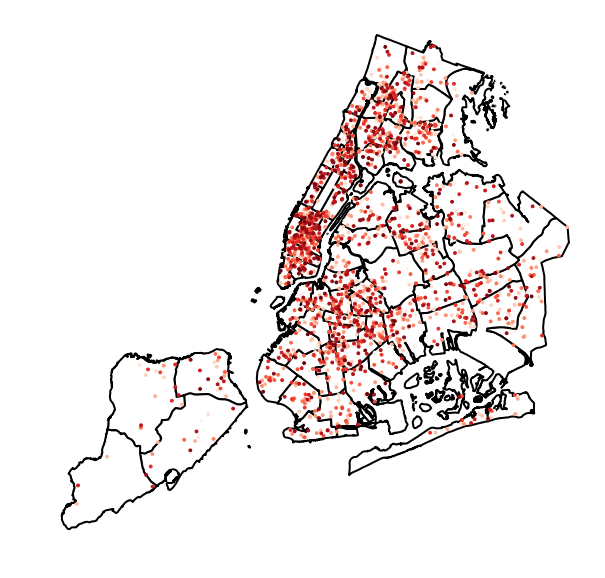

In [88]:
fig, ax = cp.choroplethNYC(precincts, color="white", edgecolor="black", lw=2)
gdfS100.plot(ax=ax, cmap='Reds', markersize=8)

#### Map of specific crime locations when wind bearing is southerly

## Northerly Winds

In [74]:
dfNorth = dfSeven.loc[(dfSeven['windBearing'] <= 22.5) | (dfSeven['windBearing'] >= 337.5)]

geometry = [Point(xy) for xy in zip(dfNorth.Longitude, dfNorth.Latitude)]
crs = {'init': 'epsg:4326'}
gdfNorth = GeoDataFrame(dfNorth, crs=crs, geometry=geometry)

In [75]:
gdfN100 = gdfNorth.iloc[::100, :]
gdfN1000 = gdfNorth.iloc[::1000, :]

### Plotting Northerly Crimes

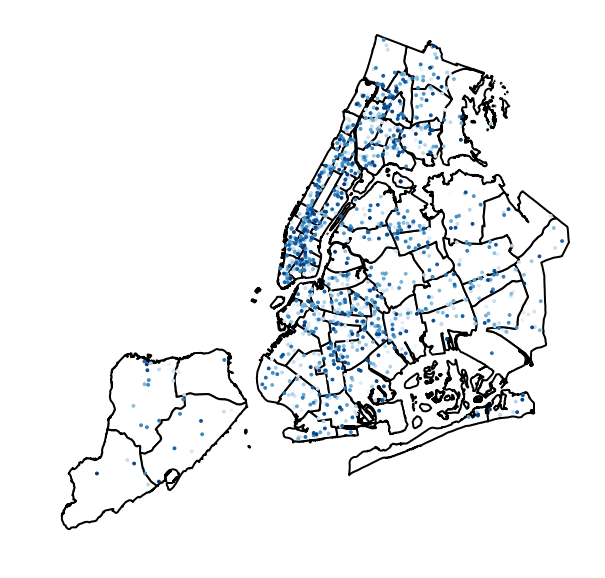

In [76]:
fig, ax = cp.choroplethNYC(precincts, color="white", edgecolor="black", lw=2)
gdfN100.plot(ax=ax, cmap='Blues', markersize=8);

#### Looking at both maps, you can eyeball that there are fewer crimes when the winds are northerly, but there doesn't appear to be much of a different in the spacial distribution of crime. Let's take a look at choropleths to see if they offer a bit more insight

## Southerly Wind Choropleth

In [89]:
dfSouthPrecinct = dfSouth.groupby('ADDR_PCT_CD').size()
dfSouthPrecinct = pd.DataFrame(dfSouthPrecinct).reset_index()
dfSouthPrecinct.columns = ['precinct', 'Count_crime']

In [90]:
gdfSouthPrecinct = precincts.merge(dfSouthPrecinct, on='precinct')

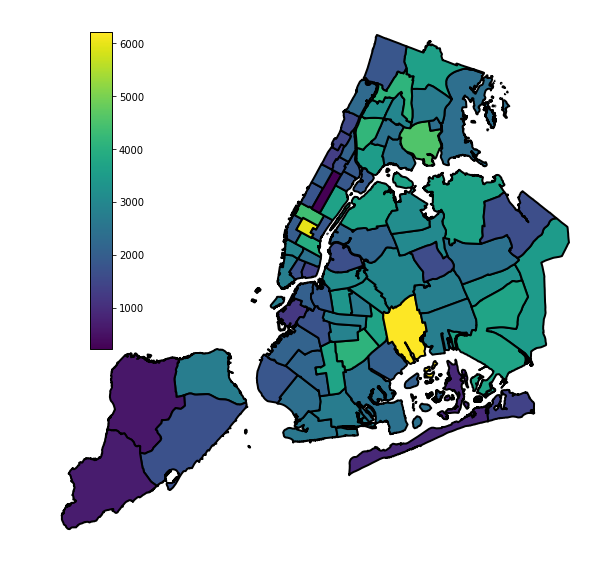

In [91]:
cp.choroplethNYC(gdfSouthPrecinct, column='Count_crime', color="white", edgecolor="black", lw=2);

## Northerly Wind Choropleth

In [80]:
dfNorthPrecinct = dfNorth.groupby('ADDR_PCT_CD').size()
dfNorthPrecinct = pd.DataFrame(dfNorthPrecinct).reset_index()
dfNorthPrecinct.columns = ['precinct', 'Count_crime']

In [81]:
gdfNorthPrecinct = precincts.merge(dfNorthPrecinct, on='precinct')

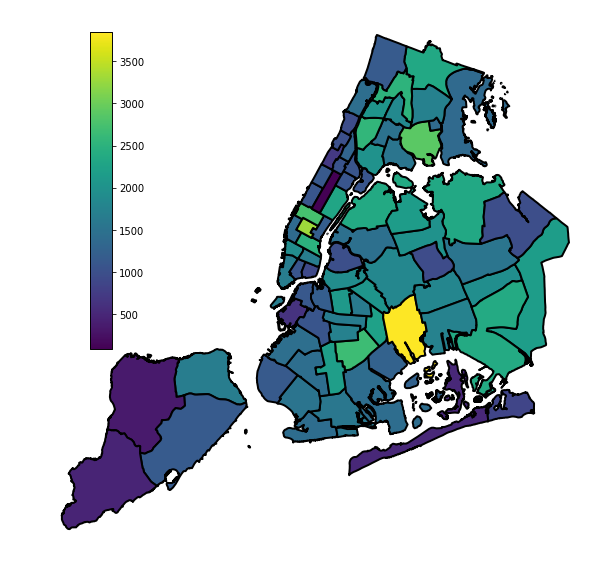

In [82]:
cp.choroplethNYC(gdfNorthPrecinct, column='Count_crime', color="white", edgecolor="black", lw=2);

### Comparing both choropleths, we see that there isn't a locative distinction of crime levels when it comes to wind bearing. However, the upper limit of crime in the southerly choropleth (~6000) is much higher than in the northerly (~3700). 

---

# Testing Additional Hypotheses

### Arson and precipitation accumulation

In [108]:
dfArson = df.loc[df['OFNS_DESC'] == 'ARSON']

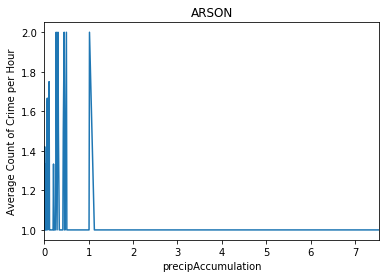

In [130]:
weatherCorrelation(dfArson, 'ARSON', 'precipAccumulation', regression=False);

### Loitering and precipitation accumulation

In [110]:
dfLoit = df.loc[df['OFNS_DESC'] == 'LOITERING']

In [112]:
len(dfLoit)

21

#### There are only 21 instances of Loitering, and only one of these occured with rain. We do not have enough data to test 

### Intoxicated & Imparied Driving and temperature

In [113]:
dfIntox = df.loc[df['OFNS_DESC'] == 'INTOXICATED & IMPAIRED DRIVING']


INTOXICATED & IMPAIRED DRIVING Regression Results:

R-Squared Value:  0.364078376673 
P-Value:  6.10247124786e-11


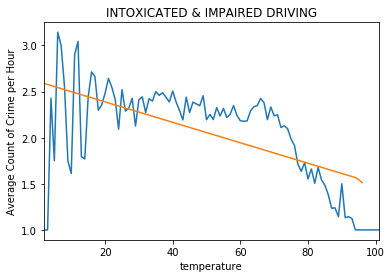

In [131]:
weatherCorrelation(dfIntox, 'INTOXICATED & IMPAIRED DRIVING', 'temperature', outliers=False, regression=True);

### Public Order and apparent temperature

In [132]:
dfDisorder = df.loc[df['OFNS_DESC'] == 'OFF. AGNST PUB ORD SENSBLTY &']


OFF. AGNST PUB ORD SENSBLTY & Regression Results:

R-Squared Value:  0.596959340047 
P-Value:  7.44056500816e-17


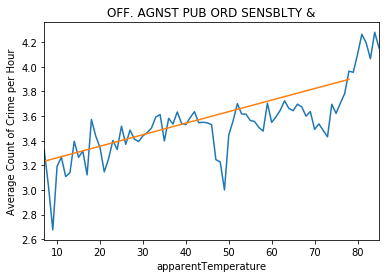

In [133]:
weatherCorrelation(dfDisorder, 'OFF. AGNST PUB ORD SENSBLTY &', 'apparentTemperature', outliers=True, regression=True);

---

# Testing our found-correlations on Precinct 75

In [116]:
df75 = dfSeven.loc[dfSeven['ADDR_PCT_CD'] == 75]

In [117]:
df75Full = df.loc[df['ADDR_PCT_CD'] == 75]

#### 7 Major Felonies & Temperature

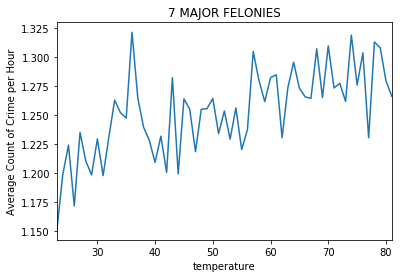

In [129]:
weatherCorrelation(df75, '7 MAJOR FELONIES', 'temperature', regression=False, outliers=True);

#### 7 Major Felonies & Wind Bearing

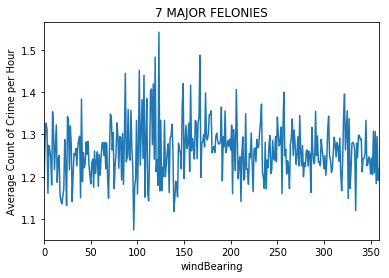

In [120]:
weatherCorrelation(df75, '7 MAJOR FELONIES', 'windBearing', regression=False);

#### Burglary & Temperature

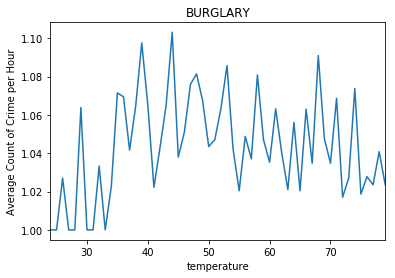

In [123]:
weatherCorrelation(df75Full, 'BURGLARY', 'temperature', regression=False, outliers=True);

#### Grand Larceny & Dew Point

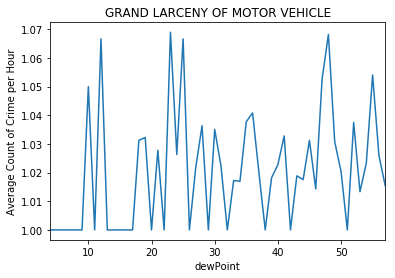

In [124]:
weatherCorrelation(df75Full, 'GRAND LARCENY OF MOTOR VEHICLE', 'dewPoint', regression=False, outliers=True);

#### Impaired Driving & Temperature

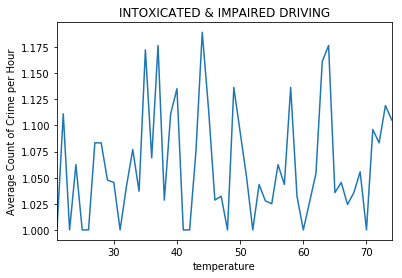

In [125]:
weatherCorrelation(df75Full, 'INTOXICATED & IMPAIRED DRIVING', 'temperature', regression=False, outliers=True);

#### Public Order & Apparent Temperature

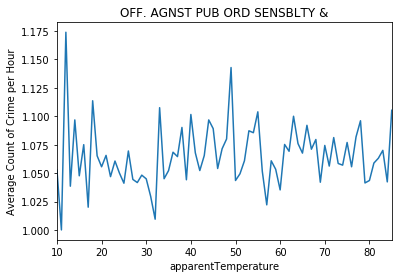

In [126]:
weatherCorrelation(df75Full, 'OFF. AGNST PUB ORD SENSBLTY &', 'apparentTemperature', regression=False, outliers=True);

---

# Considering Correlations Across Precincts

In [103]:
# Defining our new function to include precinct as a variable

def precinctCorrelation (dataframe, crime, weatherType, precinct, outliers=False):
    
    """Does the same things as our earlier function, but allows us to specify the precicnt we wish to look at.
    Also removes plotting functionality"""
    
    # Reducing dataframe based on precinct
    
    dataframe = dataframe.loc[dataframe['ADDR_PCT_CD'] == precinct]
    
    # Reducing dataframe based on selected crime type (listing no crime yields all results
    if crime == '7 MAJOR FELONIES':
        dataframe = dataframe
    else:
        dataframe = dataframe.loc[dataframe['OFNS_DESC'] == crime]
    
  # Removing weather outliers - first and last fifth
    
    if outliers == True:
        outCount = ((dataframe[weatherType].max() - dataframe[weatherType].min()) / 5)
        weatherMin = dataframe[weatherType].min() + outCount
        weatherMax = dataframe[weatherType].max() - outCount
        dataframe = dataframe[(dataframe[weatherType] >= weatherMin) & (dataframe[weatherType] <= weatherMax)]
    else:
        dataframe = dataframe
        
    # Reducing crime type by weather event
    
    dfCrimesByWeather = dataframe.groupby(weatherType).size()
    dfCrimesByWeather = pd.DataFrame(dfCrimesByWeather).reset_index()
    dfCrimesByWeather.columns = [weatherType, 'Count_crime']
    
    # Calculating number of hours of each weather pattern
    
    dfWeatherNorm = dataframe.groupby([weatherType,'datetime_adj']).size()
    dfWeatherNorm = pd.DataFrame(dfWeatherNorm).reset_index()
    dfWeatherByHour = dfWeatherNorm.groupby(weatherType).size()
    dfWeatherByHour = pd.DataFrame(dfWeatherByHour).reset_index()
    dfWeatherByHour.columns = [weatherType, 'Count_hour']

    # Getting average Crime per Hour
    
    dfWeatherNormalized = pd.merge(dfCrimesByWeather, dfWeatherByHour, on=weatherType)
    dfWeatherNormalized['CrimePerHour'] = dfWeatherNormalized.Count_crime / dfWeatherNormalized.Count_hour
    
    # Fit a regression model
    
    if weatherType == 'windBearing':
        weatherMod = smf.ols("CrimePerHour ~ (windBearing + (windBearing**2))", data=dfWeatherNormalized)
    else:
        weatherMod = smf.ols("CrimePerHour ~ " + weatherType, data=dfWeatherNormalized)
    
    weatherFit = weatherMod.fit()
    weatherFitLine = weatherFit.fittedvalues
    
    x = weatherFit.summary()
    rSqu = weatherFit.rsquared
    pValue = weatherFit.pvalues[1]

    # Return precinct data as a dictionary
    
    precinctDict = {'Precinct': precinct, 'R-Squared': rSqu, 'P-Value': pValue, 'Crime': crime}
    
    return precinctDict

In [94]:
dfSeven.head()

level_0  index  CMPLNT_NUM CMPLNT_FR_DT CMPLNT_FR_TM CMPLNT_TO_DT  \
0        1      1   153401121   12/31/2015     23:36:00          NaN   
1        5      5   365661343   12/31/2015     23:18:00   12/31/2015   
2       12     12   898496564   12/31/2015     23:00:00          NaN   
3       13     13   566081066   12/31/2015     23:00:00          NaN   
4       15     15   715942154   12/31/2015     23:00:00   12/31/2015   

  CMPLNT_TO_TM      RPT_DT  KY_CD                        OFNS_DESC  \
0          NaN  12/31/2015    101  MURDER & NON-NEGL. MANSLAUGHTER   
1     23:25:00  12/31/2015    106                   FELONY ASSAULT   
2          NaN  12/31/2015    109                    GRAND LARCENY   
3          NaN  12/31/2015    109                    GRAND LARCENY   
4     23:05:00  12/31/2015    105                          ROBBERY   

          ...          precipType pressure summary temperature          time  \
0         ...                 NaN   1018.0   Clear        42.0  1.451624e+09   
1         ...                 NaN   1019.0   Clear        43.0  1.451621e+09   
2         ...                 NaN   1019.0   Clear        43.0  1.451621e+09   
3         ...                 NaN   1019.0   Clear        43.0  1.451621e+09   
4         ...                 NaN   1019.0   Clear        43.0  1.451621e+09   

  visibility  windBearing windSpeed          datetime_y        datetime_adj  
0       10.0        313.0       9.0 2016-01-01 05:00:00 2016-01-01 00:00:00  
1       10.0        308.0      10.0 2016-01-01 04:00:00 2015-12-31 23:00:00  
2       10.0        308.0      10.0 2016-01-01 04:00:00 2015-12-31 23:00:00  
3       10.0        308.0      10.0 2016-01-01 04:00:00 2015-12-31 23:00:00  
4       10.0        308.0      10.0 2016-01-01 04:00:00 2015-12-31 23:00:00  

[5 rows x 48 columns]

In [96]:
dfSevenPrecincts = dfSeven.drop(['level_0', 'index'], axis=1)
dfSevenPrecincts = pd.DataFrame(dfSevenPrecincts).reset_index()
dfSevenPrecincts.head()

index  CMPLNT_NUM CMPLNT_FR_DT CMPLNT_FR_TM CMPLNT_TO_DT CMPLNT_TO_TM  \
0      0   153401121   12/31/2015     23:36:00          NaN          NaN   
1      1   365661343   12/31/2015     23:18:00   12/31/2015     23:25:00   
2      2   898496564   12/31/2015     23:00:00          NaN          NaN   
3      3   566081066   12/31/2015     23:00:00          NaN          NaN   
4      4   715942154   12/31/2015     23:00:00   12/31/2015     23:05:00   

       RPT_DT  KY_CD                        OFNS_DESC  PD_CD  \
0  12/31/2015    101  MURDER & NON-NEGL. MANSLAUGHTER    NaN   
1  12/31/2015    106                   FELONY ASSAULT  109.0   
2  12/31/2015    109                    GRAND LARCENY  406.0   
3  12/31/2015    109                    GRAND LARCENY  415.0   
4  12/31/2015    105                          ROBBERY  386.0   

          ...         precipType pressure summary temperature          time  \
0         ...                NaN   1018.0   Clear        42.0  1.451624e+09   
1         ...                NaN   1019.0   Clear        43.0  1.451621e+09   
2         ...                NaN   1019.0   Clear        43.0  1.451621e+09   
3         ...                NaN   1019.0   Clear        43.0  1.451621e+09   
4         ...                NaN   1019.0   Clear        43.0  1.451621e+09   

   visibility windBearing windSpeed          datetime_y        datetime_adj  
0        10.0       313.0       9.0 2016-01-01 05:00:00 2016-01-01 00:00:00  
1        10.0       308.0      10.0 2016-01-01 04:00:00 2015-12-31 23:00:00  
2        10.0       308.0      10.0 2016-01-01 04:00:00 2015-12-31 23:00:00  
3        10.0       308.0      10.0 2016-01-01 04:00:00 2015-12-31 23:00:00  
4        10.0       308.0      10.0 2016-01-01 04:00:00 2015-12-31 23:00:00  

[5 rows x 47 columns]

In [97]:
intPre = []

for i in dfSeven['ADDR_PCT_CD'].unique()[:-1]:
    intPre.append(int(i))

In [106]:
dfPrecinct = pd.DataFrame(columns=['Precinct', 'R-Squared', 'P-Value', 'Crime'])

for p in intPre:
    data = precinctCorrelation(dfSeven, '7 MAJOR FELONIES', 'temperature', p)
    dfPrecinct = dfPrecinct.append(data, ignore_index=True)

In [107]:
dfPrecinct = dfPrecinct.sort('R-Squared', ascending=False)
dfPrecinct.head(20)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


Precinct  R-Squared       P-Value             Crime
5       75.0   0.348365  2.473465e-10  7 MAJOR FELONIES
25      40.0   0.302481  7.790408e-09  7 MAJOR FELONIES
57      68.0   0.147211  1.597621e-04  7 MAJOR FELONIES
15      44.0   0.145273  1.275135e-04  7 MAJOR FELONIES
54      46.0   0.143238  1.557610e-04  7 MAJOR FELONIES
47     108.0   0.142352  1.392128e-04  7 MAJOR FELONIES
31      18.0   0.134365  2.218104e-04  7 MAJOR FELONIES
37      52.0   0.128962  3.787279e-04  7 MAJOR FELONIES
2       14.0   0.119964  4.156302e-04  7 MAJOR FELONIES
74     100.0   0.116059  1.017590e-03  7 MAJOR FELONIES
45      48.0   0.109304  1.209138e-03  7 MAJOR FELONIES
16     113.0   0.103975  1.620477e-03  7 MAJOR FELONIES
10      72.0   0.100722  1.828192e-03  7 MAJOR FELONIES
12     112.0   0.100214  1.775291e-03  7 MAJOR FELONIES
8      115.0   0.097480  2.187470e-03  7 MAJOR FELONIES
46     104.0   0.092746  2.841669e-03  7 MAJOR FELONIES
17      76.0   0.089315  4.007489e-03  7 MAJOR FELONIES
61     102.0   0.081272  4.873187e-03  7 MAJOR FELONIES
24      43.0   0.078950  5.552976e-03  7 MAJOR FELONIES
27      69.0   0.076277  7.049646e-03  7 MAJOR FELONIES